In [1]:
import sys
sys.path.append('../')

In [2]:
import time
import os

import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import tensorflow as tf
tf.__version__

'2.0.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs


In [4]:
from tensorflow.keras.metrics import Metric
class RSquare(Metric):
    """Compute R^2 score.
     This is also called as coefficient of determination.
     It tells how close are data to the fitted regression line.
     - Highest score can be 1.0 and it indicates that the predictors
       perfectly accounts for variation in the target.
     - Score 0.0 indicates that the predictors do not
       account for variation in the target.
     - It can also be negative if the model is worse.
     Usage:
     ```python
     actuals = tf.constant([1, 4, 3], dtype=tf.float32)
     preds = tf.constant([2, 4, 4], dtype=tf.float32)
     result = tf.keras.metrics.RSquare()
     result.update_state(actuals, preds)
     print('R^2 score is: ', r1.result().numpy()) # 0.57142866
    ```
    """

    def __init__(self, name='r_square', dtype=tf.float32):
        super(RSquare, self).__init__(name=name, dtype=dtype)
        self.squared_sum = self.add_weight("squared_sum", initializer="zeros")
        self.sum = self.add_weight("sum", initializer="zeros")
        self.res = self.add_weight("residual", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        self.squared_sum.assign_add(tf.reduce_sum(y_true**2))
        self.sum.assign_add(tf.reduce_sum(y_true))
        self.res.assign_add(
            tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred))))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        mean = self.sum / self.count
        total = self.squared_sum - 2 * self.sum * mean + self.count * mean**2
        return 1 - (self.res / total)

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.squared_sum.assign(0.0)
        self.sum.assign(0.0)
        self.res.assign(0.0)
        self.count.assign(0.0)

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (LinearLocator, MultipleLocator, FormatStrFormatter)
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = ((8/2.54), (6/2.54))
plt.rcParams["font.family"] = "Arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 11})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.spines.top'] = False
# plt.rcParams['axes.edgecolor'] = 
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

In [7]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

## Data preparation

### Hyperparameters

In [8]:
BEST_PATHS       = ['./models/best_MLP.h5', 
                    './models/best_LSTM.h5',
                    './models/best_AE_LSTM.h5',
                    './models/best_BiLSTM.h5',
                    './models/best_AE_BiLSTM.h5']
TRANS_BEST_PATHS = ['./models/trans_MLP.h5', 
                    './models/trans_LSTM.h5',
                    './models/trans_AE_LSTM.h5',
                    './models/trans_BiLSTM.h5',
                    './models/trans_AE_BiLSTM.h5']
RAW_BEST_PATHS   = ['./models/raw_MLP.h5', 
                    './models/raw_LSTM.h5',
                    './models/raw_AE_LSTM.h5',
                    './models/raw_BiLSTM.h5',
                    './models/raw_AE_BiLSTM.h5']
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_HIDDEN = 256

### data loading

In [9]:
l = np.load('./env_set/val_dataset.npz')
train_input = l['train_input']
train_label = l['train_label']
test_input = l['test_input']
test_label = l['test_label']
MAXS = l['MAXS']
MINS = l['MINS']

TIME_STEPS = l['TIME_STEPS']
OUTPUT_SIZE = l['OUTPUT_SIZE']
NUM_FEATURES = train_input.shape[-1]

In [10]:
print(train_input.shape)
print(train_label.shape)
print()
print(test_input.shape)
print(test_label.shape)

(9731, 24, 5)
(9731, 24, 5)

(21084, 24, 5)
(21084, 24, 5)


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

# Transfer learning - AE_LSTM

### Pre-trained AE loading

In [12]:
class RetrainLayer(tf.keras.layers.Layer):
    def __init__(self, num_hidden, activation=tf.nn.relu):
        super(RetrainLayer, self).__init__()
        self.num_hidden = num_hidden
        
        self.dense = tf.keras.layers.Dense(self.num_hidden, activation=activation, kernel_initializer='he_uniform')
        
    def call(self, inp):
        return self.dense(inp)

In [13]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, encoding_size):
        super(Encoder, self).__init__()
        
        self.num_hiddens = num_hiddens
        self.encoding_size = encoding_size
        
        self.denses = [tf.keras.layers.Dense(self.num_hiddens[_], activation=tf.nn.relu, kernel_initializer='he_uniform')
                       for _ in range(len(self.num_hiddens))]
        
        self.output_layer = tf.keras.layers.Dense(self.encoding_size, activation=tf.nn.sigmoid)
        
    def call(self, inp):
        for _ in range(len(self.num_hiddens)):
            inp = self.denses[_](inp)
        
        return self.output_layer(inp)        

In [14]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_hiddens, original_size):
        super(Decoder, self).__init__()
        
        self.num_hiddens = num_hiddens[::-1]
        self.original_size = original_size
        
        self.denses = [tf.keras.layers.Dense(self.num_hiddens[_], activation=tf.nn.relu, kernel_initializer='he_uniform')
                       for _ in range(len(self.num_hiddens))]
        
    def call(self, inp):
        for _ in range(len(self.num_hiddens)):
            inp = self.denses[_](inp)
        
        return inp

In [15]:
class Autoencoder(tf.keras.Model):
    def __init__(self, num_hiddens, encoding_size, original_size):
        super(Autoencoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.encoding_size = encoding_size
        self.original_size = original_size
        
        self.in_retrain_layer = RetrainLayer(self.num_hiddens[0])
        self.encoder = Encoder(self.num_hiddens, self.encoding_size)
        self.decoder = Decoder(self.num_hiddens, self.original_size)
        self.out_retrain_layer = RetrainLayer(self.original_size, activation = tf.nn.sigmoid)
        
    def call(self, inp, need_code=False, decoding=None):
        inp = self.in_retrain_layer(inp)
        encoded_values = self.encoder(inp)
        if decoding is not None:
            decoding = self.decoder(decoding)
            return self.out_retrain_layer(decoding)
        if not need_code:
            encoded_values = self.decoder(encoded_values)
            return self.out_retrain_layer(encoded_values)
        else:
            return encoded_values

In [16]:
num_hiddens = [32, 16]
encoding_size = 8
original_size = 5
autoencoder = Autoencoder(num_hiddens, encoding_size, original_size)

In [17]:
autoencoder_copy = Autoencoder(num_hiddens, encoding_size, original_size)

In [18]:
autoencoder_copy.load_weights('./checkpoints/trained_AE')
autoencoder_copy.save_weights('./checkpoints/used_AE')
autoencoder_copy.load_weights('./checkpoints/used_AE')

### Transfer learning AE

In [19]:
class TransAE(tf.keras.Model):
    def __init__(self, num_hiddens, trained_encoder, trained_decoder):
        super(TransAE, self).__init__()
        self.num_hiddens = num_hiddens
        self.encoding_size = encoding_size
        self.original_size = original_size
        
        self.in_retrain_layer = RetrainLayer(self.num_hiddens[0])
        self.encoder = trained_encoder
        self.decoder = trained_decoder
        self.out_retrain_layer = RetrainLayer(self.original_size, activation = tf.nn.sigmoid)
        
    def call(self, inp, need_code=False, decoding=None):
        inp = self.in_retrain_layer(inp)
        encoded_values = self.encoder(inp)
        if decoding is not None:
            decoding = self.decoder(decoding)
            return self.out_retrain_layer(decoding)
        if not need_code:
            encoded_values = self.decoder(encoded_values)
            return self.out_retrain_layer(encoded_values)
        else:
            return encoded_values

In [20]:
autoencoder_copy.trainable = False

In [21]:
for layer in autoencoder_copy.layers:
    print(layer)

In [22]:
trans_ae = TransAE(num_hiddens, autoencoder_copy.get_layer(index=1), autoencoder_copy.get_layer(index=2))
trans_opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [23]:
for layer in trans_ae.layers:
    print(layer)

In [24]:
for layer in trans_ae.layers:
    print(layer.trainable)

True
False
False
True


In [25]:
def loss(model, original):
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
    return reconstruction_error

In [26]:
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)

In [27]:
trainset = np.concatenate([train_input, train_label], axis=0).astype(np.float32)
testset = np.concatenate([test_input, test_label], axis=0).astype(np.float32)

In [28]:
ae_train_dataset = tf.data.Dataset.from_tensor_slices((trainset, trainset))
ae_train_dataset = ae_train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
ae_test_dataset = tf.data.Dataset.from_tensor_slices((testset, testset))
ae_test_dataset = ae_test_dataset.batch(BATCH_SIZE)

In [29]:
EPOCHS = 150
prev_test_loss = 100.0
count = 0
for epoch in range(EPOCHS):
    for step, (inp, tar) in enumerate(ae_train_dataset):
        train(loss, trans_ae, trans_opt, inp)
        loss_values = loss(trans_ae, inp)

        if step % 100 == 0:
            test_loss = 0
            for step_, (inp_, tar_) in enumerate(ae_test_dataset):
                test_loss += loss(trans_ae, inp_)

                if step_ > 500:
                    test_loss /= 100
                    break
            if test_loss.numpy() < prev_test_loss:
                trans_ae.save_weights('./models/trans_ae')
                prev_test_loss = test_loss.numpy()
                print('Model saved.')
                count = 0
            elif (test_loss.numpy() - prev_test_loss) < 0.01:
                count += 1
                if count > 200:
                    break
            print('Epoch {} batch {} train loss: {:.4f} test loss: {:.4f}'
                  .format(epoch, step, loss_values.numpy(), test_loss.numpy()))
    if count > 200:
        print('Early stopping.')
        break

Model saved.
Epoch 0 batch 0 train loss: 0.1477 test loss: 0.5893
Model saved.
Epoch 0 batch 100 train loss: 0.0290 test loss: 0.1213
Model saved.
Epoch 0 batch 200 train loss: 0.0158 test loss: 0.0902
Model saved.
Epoch 0 batch 300 train loss: 0.0118 test loss: 0.0761
Model saved.
Epoch 0 batch 400 train loss: 0.0161 test loss: 0.0695
Epoch 0 batch 500 train loss: 0.0107 test loss: 0.0729
Model saved.
Epoch 0 batch 600 train loss: 0.0120 test loss: 0.0686
Model saved.
Epoch 0 batch 700 train loss: 0.0119 test loss: 0.0598
Epoch 0 batch 800 train loss: 0.0093 test loss: 0.0599
Model saved.
Epoch 0 batch 900 train loss: 0.0080 test loss: 0.0552
Model saved.
Epoch 0 batch 1000 train loss: 0.0109 test loss: 0.0530
Epoch 0 batch 1100 train loss: 0.0092 test loss: 0.0549
Model saved.
Epoch 0 batch 1200 train loss: 0.0068 test loss: 0.0508
Model saved.
Epoch 0 batch 1300 train loss: 0.0080 test loss: 0.0463
Model saved.
Epoch 0 batch 1400 train loss: 0.0058 test loss: 0.0425
Model saved.
Epo

In [30]:
trans_ae.load_weights('./models/trans_ae')
trans_ae.trainable = True
trans_opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE/10)

In [31]:
def loss_(model, original):
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
    return reconstruction_error

In [32]:
def train_(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)

In [33]:
EPOCHS = 150
prev_test_loss = 100.0
count = 0
for epoch in range(EPOCHS):
    for step, (inp, tar) in enumerate(ae_train_dataset):
        train_(loss_, trans_ae, trans_opt, inp)
        loss_values = loss_(trans_ae, inp)

        if step % 100 == 0:
            test_loss = 0
            for step_, (inp_, tar_) in enumerate(ae_test_dataset):
                test_loss += loss_(trans_ae, inp_)

                if step_ > 500:
                    test_loss /= 100
                    break
            if test_loss.numpy() < prev_test_loss:
                trans_ae.save_weights('./models/trans_ae')
                prev_test_loss = test_loss.numpy()
                print('Model saved.')
                count = 0
            elif (test_loss.numpy() - prev_test_loss) < 0.01:
                count += 1
                if count > 200:
                    break
            print('Epoch {} batch {} train loss: {:.4f} test loss: {:.4f}'
                  .format(epoch, step, loss_values.numpy(), test_loss.numpy()))
    if count > 200:
        print('Early stopping.')
        break

Model saved.
Epoch 0 batch 0 train loss: 0.0003 test loss: 0.0019
Model saved.
Epoch 0 batch 100 train loss: 0.0001 test loss: 0.0010
Epoch 0 batch 200 train loss: 0.0001 test loss: 0.0010
Epoch 0 batch 300 train loss: 0.0001 test loss: 0.0010
Model saved.
Epoch 0 batch 400 train loss: 0.0001 test loss: 0.0010
Model saved.
Epoch 0 batch 500 train loss: 0.0001 test loss: 0.0010
Epoch 0 batch 600 train loss: 0.0001 test loss: 0.0010
Epoch 0 batch 700 train loss: 0.0001 test loss: 0.0010
Model saved.
Epoch 0 batch 800 train loss: 0.0001 test loss: 0.0010
Model saved.
Epoch 0 batch 900 train loss: 0.0001 test loss: 0.0010
Epoch 0 batch 1000 train loss: 0.0001 test loss: 0.0010
Model saved.
Epoch 0 batch 1100 train loss: 0.0001 test loss: 0.0010
Epoch 0 batch 1200 train loss: 0.0001 test loss: 0.0010
Epoch 0 batch 1300 train loss: 0.0001 test loss: 0.0010
Model saved.
Epoch 0 batch 1400 train loss: 0.0001 test loss: 0.0009
Epoch 0 batch 1500 train loss: 0.0001 test loss: 0.0010
Epoch 0 batc

In [34]:
trans_ae.load_weights('./models/trans_ae')
print('transfered AE is ready.')

transfered AE is ready.


### transfer learning LSTM

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_label))
train_dataset = train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_label))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [36]:
trans_enc_train_input = []
trans_enc_train_label = []
trans_enc_test_input = []
trans_enc_test_label = []
for step, (inp, tar) in enumerate(train_dataset):
    trans_enc_train_input.append(trans_ae(inp, True))
    trans_enc_train_label.append(trans_ae(tar, True))
for step, (inp, tar) in enumerate(test_dataset):
    trans_enc_test_input.append(trans_ae(inp, True))
    trans_enc_test_label.append(trans_ae(tar, True))
trans_enc_train_input = tf.concat(trans_enc_train_input, axis=0)
trans_enc_train_label = tf.concat(trans_enc_train_label, axis=0)
trans_enc_test_input = tf.concat(trans_enc_test_input, axis=0)
trans_enc_test_label = tf.concat(trans_enc_test_label, axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [37]:
trans_enc_train_dataset = tf.data.Dataset.from_tensor_slices((trans_enc_train_input, trans_enc_train_label))
trans_enc_train_dataset = trans_enc_train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
trans_enc_test_dataset = tf.data.Dataset.from_tensor_slices((trans_enc_test_input, trans_enc_test_label))
trans_enc_test_dataset = trans_enc_test_dataset.batch(BATCH_SIZE)

In [38]:
ae_lstm_model_copy = tf.keras.models.load_model(BEST_PATHS[2])
ae_lstm_model_copy.save(TRANS_BEST_PATHS[2])
ae_lstm_model_copy.trainable = False

In [39]:
trans_ae_lstm_model = tf.keras.Sequential([ae_lstm_model_copy.get_layer(index=0), 
                                           ae_lstm_model_copy.get_layer(index=1),
                                           tf.keras.layers.Dense(encoding_size)])

In [40]:
trans_ae_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [41]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=TRANS_BEST_PATHS[2],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [42]:
trans_ae_lstm_model.fit(
    trans_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = trans_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
143/144 [============================>.] - ETA: 0s - loss: 0.0646
Epoch 00001: val_loss improved from inf to 0.00335, saving model to ./models/trans_AE_LSTM.h5
144/144 [==============================] - 7s 48ms/step - loss: 0.0641 - val_loss: 0.0033
Epoch 2/150
142/144 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 00002: val_loss improved from 0.00335 to 0.00211, saving model to ./models/trans_AE_LSTM.h5
144/144 [==============================] - 5s 37ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 3/150
143/144 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 00003: val_loss improved from 0.00211 to 0.00146, saving model to ./models/trans_AE_LSTM.h5
144/144 [==============================] - 5s 37ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 4/150
142/144 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00004: val_loss improved from 0.00146 to 0.00108, saving model to ./models/tran

In [43]:
trans_ae_lstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[2])
trans_ae_lstm_model.trainable = True
trans_ae_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
                   loss = tf.keras.losses.MeanSquaredError())

In [44]:
trans_ae_lstm_model.fit(
    trans_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = trans_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
143/144 [============================>.] - ETA: 0s - loss: 6.8073e-04
Epoch 00001: val_loss did not improve from 0.00045
144/144 [==============================] - 7s 47ms/step - loss: 6.7884e-04 - val_loss: 4.5661e-04
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 4.3018e-04
Epoch 00002: val_loss did not improve from 0.00045
144/144 [==============================] - 5s 38ms/step - loss: 4.2997e-04 - val_loss: 4.6053e-04
Epoch 3/150
143/144 [============================>.] - ETA: 0s - loss: 4.4412e-04
Epoch 00003: val_loss did not improve from 0.00045
144/144 [==============================] - 5s 38ms/step - loss: 4.4406e-04 - val_loss: 4.5564e-04
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 4.1278e-04
Epoch 00004: val_loss did not improve from 0.00045
144/144 [==============================] - 5s 37ms/step - loss: 4.1381e-04 - val_loss: 4.8806e-04
Epoch 5/150
143/144 [============

In [45]:
raw_ae = Autoencoder(num_hiddens, encoding_size, original_size)
raw_opt = tf.optimizers.Adam(learning_rate=LEARNING_RATE/10)

In [46]:
EPOCHS = 150
prev_test_loss = 100.0
count = 0
for epoch in range(EPOCHS):
    for step, (inp, tar) in enumerate(ae_train_dataset):
        train(loss, raw_ae, raw_opt, inp)
        loss_values = loss(raw_ae, inp)

        if step % 100 == 0:
            test_loss = 0
            for step_, (inp_, tar_) in enumerate(ae_test_dataset):
                test_loss += loss(raw_ae, inp_)

                if step_ > 500:
                    test_loss /= 100
                    break
            if test_loss.numpy() < prev_test_loss:
                trans_ae.save_weights('./models/raw_ae')
                prev_test_loss = test_loss.numpy()
                print('Model saved.')
                count = 0
            elif (test_loss.numpy() - prev_test_loss) < 0.01:
                count += 1
                if count > 200:
                    break
            print('Epoch {} batch {} train loss: {:.4f} test loss: {:.4f}'
                  .format(epoch, step, loss_values.numpy(), test_loss.numpy()))
    if count > 200:
        print('Early stopping.')
        break

Model saved.
Epoch 0 batch 0 train loss: 0.1021 test loss: 0.4646
Model saved.
Epoch 0 batch 100 train loss: 0.0743 test loss: 0.3391
Model saved.
Epoch 0 batch 200 train loss: 0.0435 test loss: 0.2526
Model saved.
Epoch 0 batch 300 train loss: 0.0350 test loss: 0.1908
Model saved.
Epoch 0 batch 400 train loss: 0.0279 test loss: 0.1588
Model saved.
Epoch 0 batch 500 train loss: 0.0186 test loss: 0.1197
Model saved.
Epoch 0 batch 600 train loss: 0.0190 test loss: 0.1033
Model saved.
Epoch 0 batch 700 train loss: 0.0214 test loss: 0.0886
Model saved.
Epoch 0 batch 800 train loss: 0.0134 test loss: 0.0771
Model saved.
Epoch 0 batch 900 train loss: 0.0135 test loss: 0.0688
Epoch 0 batch 1000 train loss: 0.0127 test loss: 0.0709
Model saved.
Epoch 0 batch 1100 train loss: 0.0110 test loss: 0.0613
Model saved.
Epoch 0 batch 1200 train loss: 0.0097 test loss: 0.0590
Model saved.
Epoch 0 batch 1300 train loss: 0.0114 test loss: 0.0545
Model saved.
Epoch 0 batch 1400 train loss: 0.0062 test los

In [47]:
raw_ae.load_weights('./models/raw_ae')
print('raw AE is ready.')

raw AE is ready.


In [48]:
raw_enc_train_input = []
raw_enc_train_label = []
raw_enc_test_input = []
raw_enc_test_label = []
for step, (inp, tar) in enumerate(train_dataset):
    raw_enc_train_input.append(raw_ae(inp, True))
    raw_enc_train_label.append(raw_ae(tar, True))
for step, (inp, tar) in enumerate(test_dataset):
    raw_enc_test_input.append(raw_ae(inp, True))
    raw_enc_test_label.append(raw_ae(tar, True))
raw_enc_train_input = tf.concat(raw_enc_train_input, axis=0)
raw_enc_train_label = tf.concat(raw_enc_train_label, axis=0)
raw_enc_test_input = tf.concat(raw_enc_test_input, axis=0)
raw_enc_test_label = tf.concat(raw_enc_test_label, axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [49]:
raw_enc_train_dataset = tf.data.Dataset.from_tensor_slices((raw_enc_train_input, raw_enc_train_label))
raw_enc_train_dataset = raw_enc_train_dataset.cache().shuffle(BATCH_SIZE*100).batch(BATCH_SIZE).repeat()
raw_enc_test_dataset = tf.data.Dataset.from_tensor_slices((raw_enc_test_input, raw_enc_test_label))
raw_enc_test_dataset = raw_enc_test_dataset.batch(BATCH_SIZE)

In [50]:
raw_ae_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(256, input_shape=[TIME_STEPS, encoding_size], return_sequences=True),
    tf.keras.layers.LayerNormalization(), # TEST
    tf.keras.layers.Dense(encoding_size)
])

In [51]:
raw_ae_lstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [52]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=RAW_BEST_PATHS[2],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [53]:
raw_ae_lstm_model.fit(
    raw_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = raw_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
142/144 [============================>.] - ETA: 0s - loss: 0.0274
Epoch 00001: val_loss improved from inf to 0.00148, saving model to ./models/raw_AE_LSTM.h5
144/144 [==============================] - 6s 42ms/step - loss: 0.0271 - val_loss: 0.0015
Epoch 2/150
140/144 [============================>.] - ETA: 0s - loss: 9.8128e-04
Epoch 00002: val_loss improved from 0.00148 to 0.00108, saving model to ./models/raw_AE_LSTM.h5
144/144 [==============================] - 2s 12ms/step - loss: 9.7941e-04 - val_loss: 0.0011
Epoch 3/150
140/144 [============================>.] - ETA: 0s - loss: 7.9032e-04
Epoch 00003: val_loss improved from 0.00108 to 0.00095, saving model to ./models/raw_AE_LSTM.h5
144/144 [==============================] - 2s 12ms/step - loss: 7.8724e-04 - val_loss: 9.4715e-04
Epoch 4/150
140/144 [============================>.] - ETA: 0s - loss: 8.5621e-04
Epoch 00004: val_loss improved from 0.00095 to 0.00072, saving mode

### Model evaluation

In [54]:
# Data preparation for AE
encoded_test_input = []
encoded_test_label = []
for step, (inp, tar) in enumerate(test_dataset):
    encoded_test_input.append(autoencoder(inp, True))
    encoded_test_label.append(autoencoder(tar, True))
encoded_test_input = tf.concat(encoded_test_input, axis=0)
encoded_test_label = tf.concat(encoded_test_label, axis=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [55]:
encoded_test_dataset = tf.data.Dataset.from_tensor_slices((encoded_test_input, encoded_test_label))
encoded_test_dataset = encoded_test_dataset.batch(BATCH_SIZE)

In [56]:
ae_lstm_model = tf.keras.models.load_model(BEST_PATHS[2])
trans_ae_lstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[2])
raw_ae_lstm_model = tf.keras.models.load_model(RAW_BEST_PATHS[2])

In [57]:
_ = ae_lstm_model.predict(encoded_test_dataset)
ae_lstm_pred = autoencoder(train_input[0:1, :, :], decoding=_)
_ = trans_ae_lstm_model.predict(trans_enc_test_dataset)
trans_ae_lstm_pred = trans_ae(train_input[0:1, :, :], decoding=_)
_ = raw_ae_lstm_model.predict(trans_enc_test_dataset)
raw_ae_lstm_pred = raw_ae(train_input[0:1, :, :], decoding=_)

[0, 50, 0, 50]

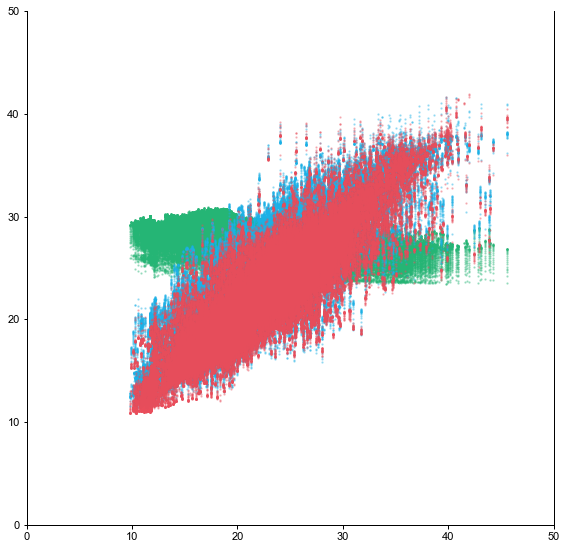

In [58]:
fig = plt.figure(figsize=((6/2.54)*4, (6/2.54)*4))

plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*ae_lstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[3], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*raw_ae_lstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[4], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*trans_ae_lstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[0], s=2, alpha=0.3
           )
plt.axis([0,50,0,50])

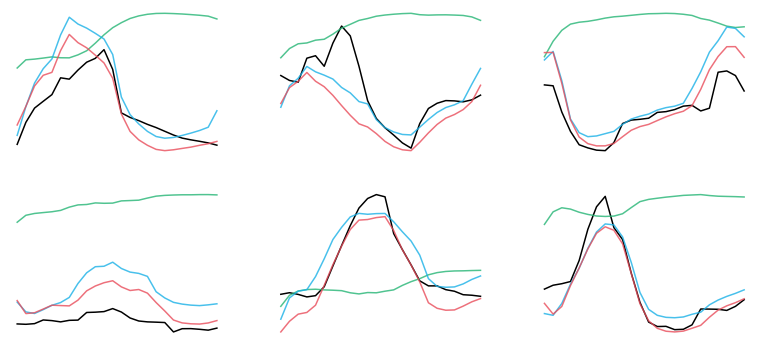

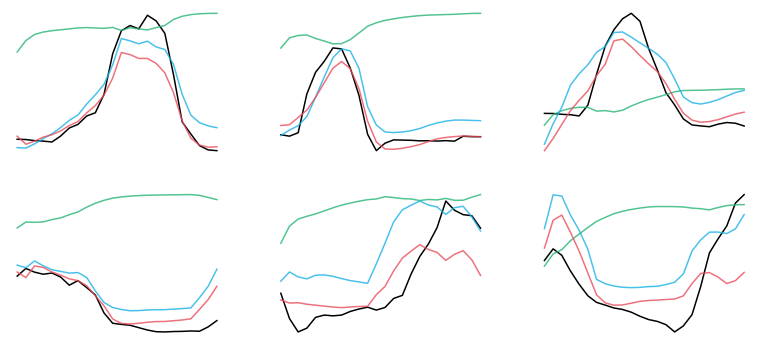

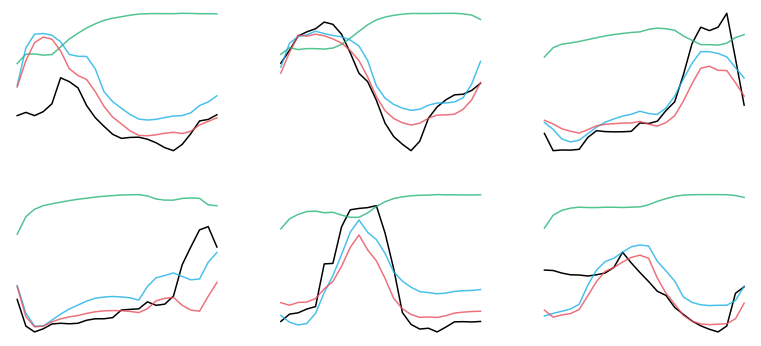

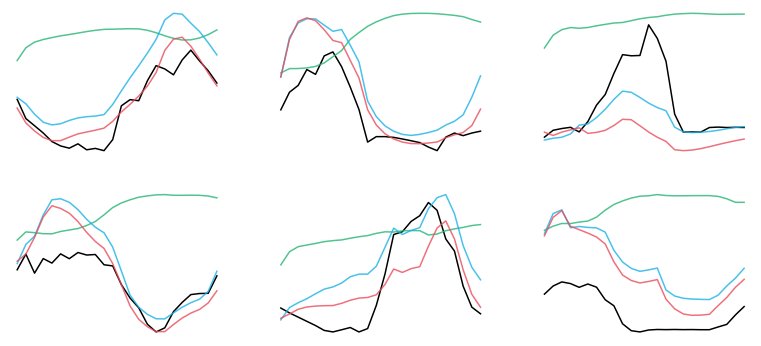

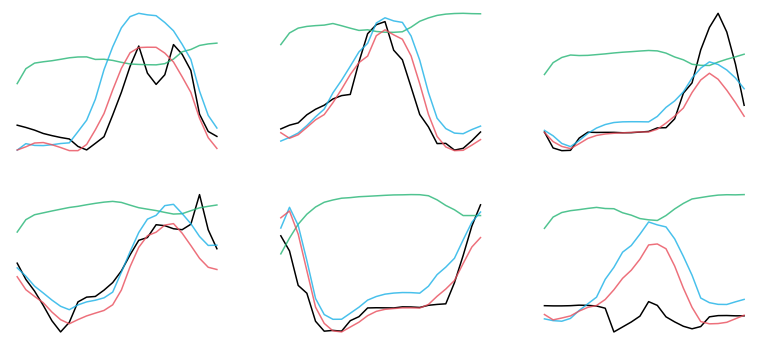

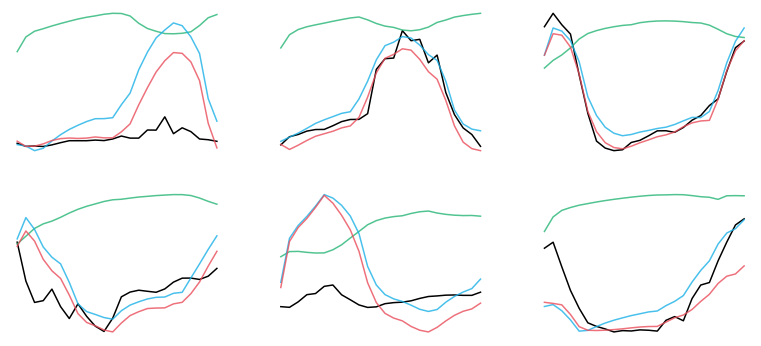

In [59]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (6):

        NUMBERS = np.arange(1, ae_lstm_pred.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*4, (6/2.54)*4))
        
        i=0
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, test_label[NUMBER, :, i], c='k', alpha=1) #measured
            expect1 = plt.plot(x_t, ae_lstm_pred[NUMBER, :, i], c=cmap[3], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, raw_ae_lstm_pred[NUMBER, :, i], c=cmap[4], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, trans_ae_lstm_pred[NUMBER, :, i], c=cmap[0], alpha=0.8) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1

### transfer learning BiLSTM

In [60]:
ae_bilstm_model_copy = tf.keras.models.load_model(BEST_PATHS[4])
ae_bilstm_model_copy.save(TRANS_BEST_PATHS[4])
ae_bilstm_model_copy.trainable = False

In [61]:
trans_ae_bilstm_model = tf.keras.Sequential([ae_bilstm_model_copy.get_layer(index=0), 
                                       ae_bilstm_model_copy.get_layer(index=1),
                                       tf.keras.layers.Dense(encoding_size)])

In [62]:
trans_ae_bilstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [63]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=TRANS_BEST_PATHS[4],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [64]:
trans_ae_bilstm_model.fit(
    trans_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = trans_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
142/144 [============================>.] - ETA: 0s - loss: 0.0799
Epoch 00001: val_loss improved from inf to 0.00345, saving model to ./models/trans_AE_BiLSTM.h5
144/144 [==============================] - 11s 74ms/step - loss: 0.0789 - val_loss: 0.0035
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00002: val_loss improved from 0.00345 to 0.00168, saving model to ./models/trans_AE_BiLSTM.h5
144/144 [==============================] - 8s 58ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/150
142/144 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00003: val_loss improved from 0.00168 to 0.00133, saving model to ./models/trans_AE_BiLSTM.h5
144/144 [==============================] - 8s 59ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 0.0010
Epoch 00004: val_loss improved from 0.00133 to 0.00109, saving model to ./mode

In [65]:
trans_ae_bilstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[4])
trans_ae_bilstm_model.trainable = True
trans_ae_bilstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
                   loss = tf.keras.losses.MeanSquaredError())

In [66]:
trans_ae_bilstm_model.fit(
    trans_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = trans_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
142/144 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 00001: val_loss did not improve from 0.00043
144/144 [==============================] - 10s 73ms/step - loss: 0.0014 - val_loss: 4.7009e-04
Epoch 2/150
143/144 [============================>.] - ETA: 0s - loss: 3.7440e-04
Epoch 00002: val_loss did not improve from 0.00043
144/144 [==============================] - 8s 57ms/step - loss: 3.7450e-04 - val_loss: 4.6126e-04
Epoch 3/150
143/144 [============================>.] - ETA: 0s - loss: 4.1265e-04
Epoch 00003: val_loss improved from 0.00043 to 0.00042, saving model to ./models/trans_AE_BiLSTM.h5
144/144 [==============================] - 8s 57ms/step - loss: 4.1182e-04 - val_loss: 4.2132e-04
Epoch 4/150
143/144 [============================>.] - ETA: 0s - loss: 3.9876e-04
Epoch 00004: val_loss did not improve from 0.00042
144/144 [==============================] - 8s 57ms/step - loss: 3.9822e-04 - val_loss: 4.

In [67]:
raw_ae_bilstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True),
                                  input_shape=[TIME_STEPS, encoding_size]),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(encoding_size)
])

In [68]:
raw_ae_bilstm_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                   loss = tf.keras.losses.MeanSquaredError())

In [69]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=RAW_BEST_PATHS[4],
        save_best_only=True,
        monitor='val_loss',
        verbose=1),
    tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,  patience=20)
]

In [70]:
raw_ae_bilstm_model.fit(
    raw_enc_train_dataset, epochs = 150,
    steps_per_epoch = 144,
    callbacks=callbacks,
    validation_data = raw_enc_test_dataset, validation_steps = 50)

Train for 144 steps, validate for 50 steps
Epoch 1/150
142/144 [============================>.] - ETA: 0s - loss: 0.0779
Epoch 00001: val_loss improved from inf to 0.00110, saving model to ./models/raw_AE_BiLSTM.h5
144/144 [==============================] - 10s 69ms/step - loss: 0.0768 - val_loss: 0.0011
Epoch 2/150
141/144 [============================>.] - ETA: 0s - loss: 8.7317e-04
Epoch 00002: val_loss improved from 0.00110 to 0.00086, saving model to ./models/raw_AE_BiLSTM.h5
144/144 [==============================] - 4s 28ms/step - loss: 8.7385e-04 - val_loss: 8.6453e-04
Epoch 3/150
141/144 [============================>.] - ETA: 0s - loss: 6.6265e-04
Epoch 00003: val_loss improved from 0.00086 to 0.00076, saving model to ./models/raw_AE_BiLSTM.h5
144/144 [==============================] - 4s 28ms/step - loss: 6.6221e-04 - val_loss: 7.5510e-04
Epoch 4/150
142/144 [============================>.] - ETA: 0s - loss: 5.5499e-04
Epoch 00004: val_loss improved from 0.00076 to 0.00057, 

### Model evaluation

In [71]:
ae_bilstm_model = tf.keras.models.load_model(BEST_PATHS[4])
trans_ae_bilstm_model = tf.keras.models.load_model(TRANS_BEST_PATHS[4])
raw_ae_bilstm_model = tf.keras.models.load_model(RAW_BEST_PATHS[4])

In [72]:
_ = ae_bilstm_model.predict(encoded_test_dataset)
ae_bilstm_pred = autoencoder(train_input[0:1, :, :], decoding=_)
_ = trans_ae_bilstm_model.predict(trans_enc_test_dataset)
trans_ae_bilstm_pred = trans_ae(train_input[0:1, :, :], decoding=_)
_ = raw_ae_bilstm_model.predict(trans_enc_test_dataset)
raw_ae_bilstm_pred = raw_ae(train_input[0:1, :, :], decoding=_)

[0, 50, 0, 50]

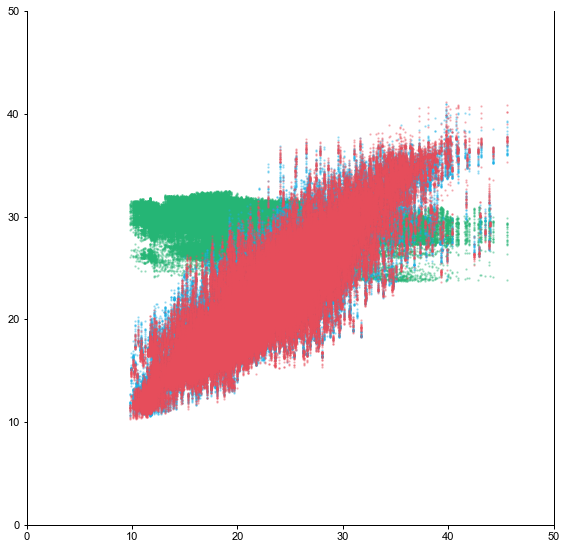

In [73]:
fig = plt.figure(figsize=((6/2.54)*4, (6/2.54)*4))

plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*ae_bilstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[3], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*raw_ae_bilstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[4], s=2, alpha=0.3
           )
plt.scatter(tf.cast(tf.reshape(((MAXS-MINS)*test_label + MINS)[:, :, 0], (-1, 1)), tf.float32),
            tf.cast(tf.reshape(((MAXS-MINS)*trans_ae_bilstm_pred + MINS)[:, :, 0], (-1, 1)), tf.float32),
            c=cmap[0], s=2, alpha=0.3
           )
plt.axis([0,50,0,50])

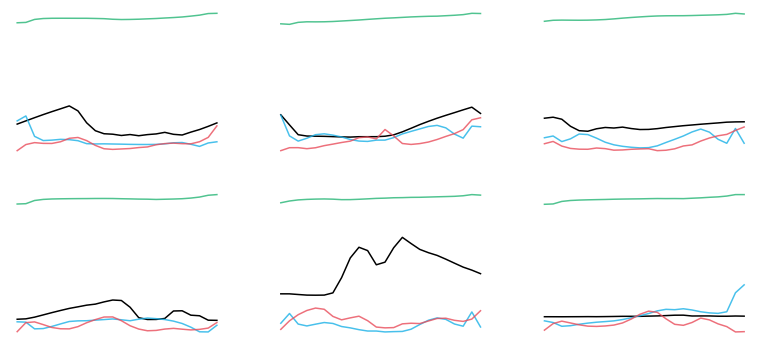

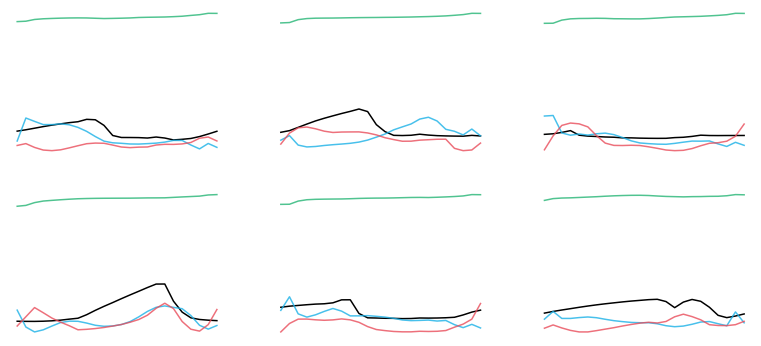

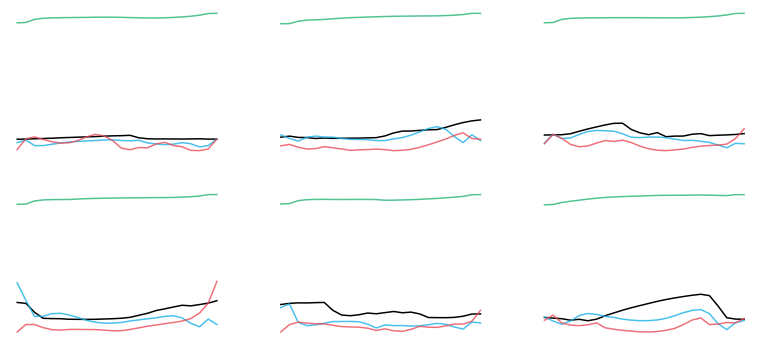

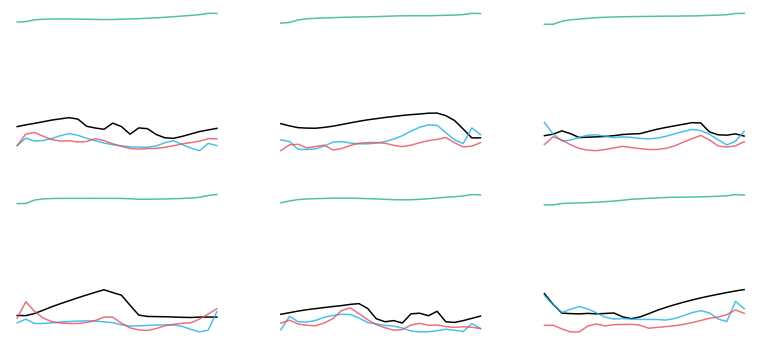

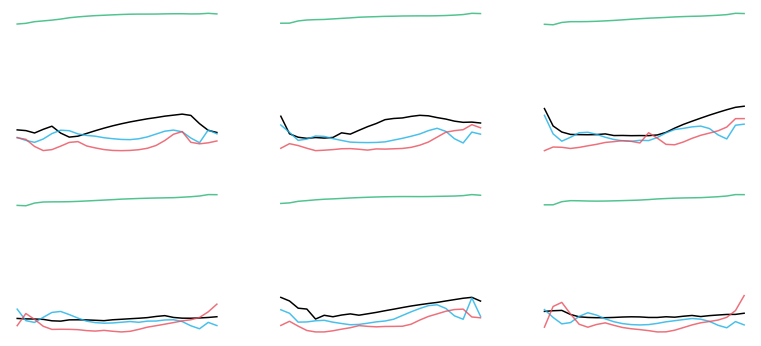

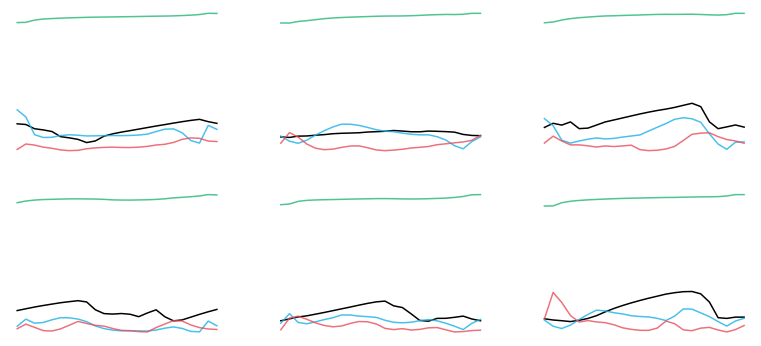

In [95]:
x_t = np.arange(0, test_label.shape[1])
for _ in range (6):

        NUMBERS = np.arange(1, ae_lstm_pred.shape[0])
        np.random.shuffle(NUMBERS)
        NUMBERS = NUMBERS[:6]
        position = 331
        fig = plt.figure(figsize=((8.5/2.54)*4, (6/2.54)*4))
        
        i=-2
        for NUMBER in NUMBERS:
            ax = plt.subplot(position)
            measured1 = plt.plot(x_t, ((MAXS-MINS)*test_label + MINS)[NUMBER, :, i], c='k', alpha=1) #measured
            expect1 = plt.plot(x_t, ae_bilstm_pred[NUMBER, :, i], c=cmap[3], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, raw_ae_bilstm_pred[NUMBER, :, i], c=cmap[4], alpha=0.8) #estimated
            expect1 = plt.plot(x_t, trans_ae_bilstm_pred[NUMBER, :, i], c=cmap[0], alpha=0.8) #estimated
            ax.axis('off')

            position += 1
        plt.show()
        _ += 1

In [79]:
ae_lstm_pred = tf.cast((MAXS-MINS)*ae_lstm_pred + MINS, tf.float32).numpy()
ae_bilstm_pred = tf.cast((MAXS-MINS)*ae_bilstm_pred + MINS, tf.float32).numpy()
raw_ae_lstm_pred = tf.cast((MAXS-MINS)*raw_ae_lstm_pred + MINS, tf.float32).numpy()
raw_ae_bilstm_pred = tf.cast((MAXS-MINS)*raw_ae_bilstm_pred + MINS, tf.float32).numpy()
trans_ae_lstm_pred = tf.cast((MAXS-MINS)*trans_ae_lstm_pred + MINS, tf.float32).numpy()
trans_ae_bilstm_pred = tf.cast((MAXS-MINS)*trans_ae_bilstm_pred + MINS, tf.float32).numpy()

In [92]:
pd.DataFrame(((MAXS-MINS)*test_label + MINS).reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_tr_test_label.csv')

In [80]:
pd.DataFrame(ae_lstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_prev_ae_lstm_pred.csv')
pd.DataFrame(ae_bilstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_prev_ae_bilstm_pred.csv')
pd.DataFrame(raw_ae_lstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_raw_ae_lstm_pred.csv')
pd.DataFrame(raw_ae_bilstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_raw_ae_bilstm_pred.csv')
pd.DataFrame(trans_ae_lstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_tr_ae_lstm_pred.csv')
pd.DataFrame(trans_ae_bilstm_pred.reshape(-1, 5), columns=['T_in', 'T_out', 'RH_in', 'CO2', 'Rad']).to_csv('./results/val_tr_ae_bilstm_pred.csv')